# InVivo AI Technical Challenge


In [1]:
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import rdMolDescriptors, Draw
from rdkit.Chem.Draw import IPythonConsole
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import random
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

## Exploring Data

Data Consists of a column with SMILES representation of molecules and twelve binary targets

In [3]:
df_data = pd.read_csv('data.csv') # Importing data
df_data.head()

,smiles,target1,target2,target3,target4,target5,target6,target7,target8,target9,target10,target11,target12
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,CCN1C(=O)NC(c2ccccc2)C1=O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0
2,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
3,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0
4,CC(O)(P(=O)(O)O)P(=O)(O)O,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0


### Class Imbalance

I examined the balance between positive and negative classes for each target. One can observe that there is a very large class imbalance. There are far more negative class (class 0) data points compared to positive class (class 1) data points, as showm below.

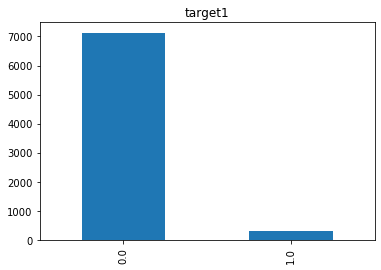

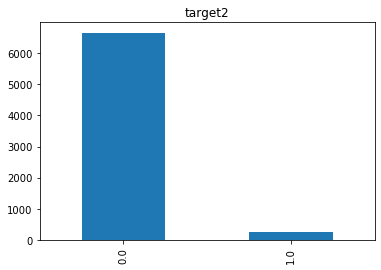

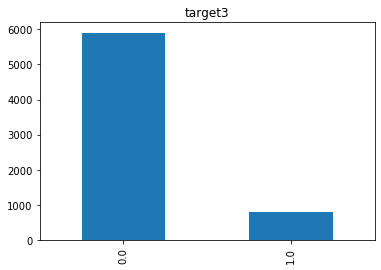

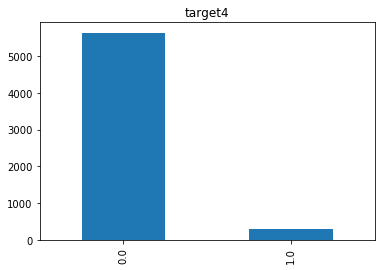

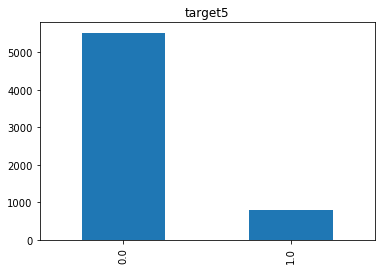

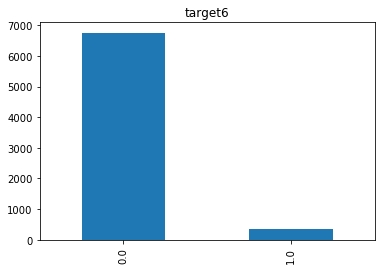

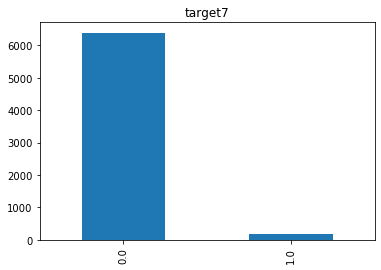

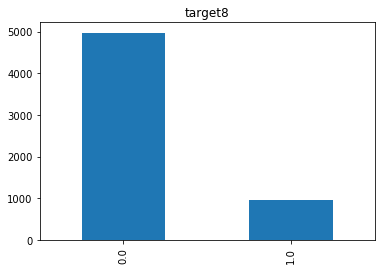

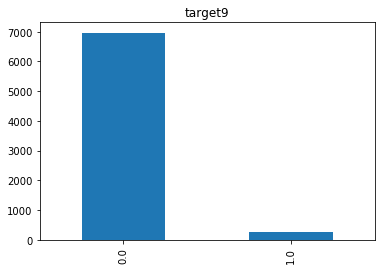

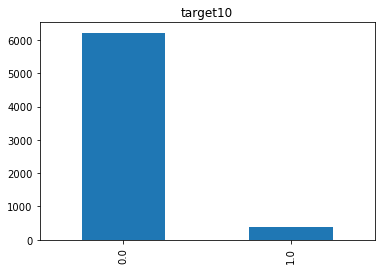

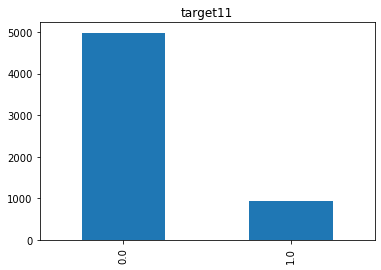

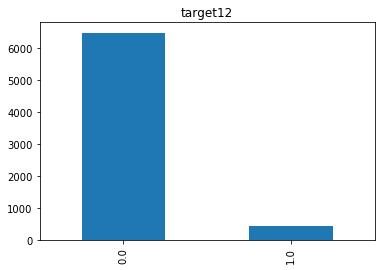

In [4]:
# Data Distribution
targets = [f'target{i}' for i in range(1, 13)]

for target in targets:
    plt.figure()
    plt.title(target)
    df_data[target].value_counts().plot.bar()
    plt.show()

### Correlation between targets

I checked if there existed any visibly strong correlation between different target - this might provide insights into whether information about a certain target can help improve the accuracy for other targets.

In [5]:
# Checking if there is any correlation between the targets
df_targets = df_data.drop(['smiles'], axis = 1)
df_targets
corr = df_targets.apply(lambda t: df_targets.corrwith(t))

In [6]:
corr

,target1,target2,target3,target4,target5,target6,target7,target8,target9,target10,target11,target12
target1,1.000000,0.565337,0.017768,0.029735,0.230872,0.197479,-0.013511,0.068428,0.058266,-0.024424,0.021329,0.021040
target2,0.565337,1.000000,0.008609,0.124251,0.226740,0.318316,0.220428,0.140357,0.190156,0.136885,0.103005,0.239362
target3,0.017768,0.008609,1.000000,0.198933,0.225118,0.101407,0.047586,0.301760,0.271949,0.114914,0.351367,0.170791
target4,0.029735,0.124251,0.198933,1.000000,0.089354,0.136735,0.080045,0.283260,0.133027,0.206848,0.337581,0.256867
target5,0.230872,0.226740,0.225118,0.089354,1.000000,0.542598,0.028606,0.186532,0.257040,0.071498,0.260495,0.131158
target6,0.197479,0.318316,0.101407,0.136735,0.542598,1.000000,0.147029,0.211954,0.226042,0.190465,0.272279,0.221381
target7,-0.013511,0.220428,0.047586,0.080045,0.028606,0.147029,1.000000,0.204099,0.243373,0.288994,0.184312,0.332107
target8,0.068428,0.140357,0.301760,0.283260,0.186532,0.211954,0.204099,1.000000,0.255896,0.275985,0.439680,0.347036
target9,0.058266,0.190156,0.271949,0.133027,0.257040,0.226042,0.243373,0.255896,1.000000,0.182150,0.213882,0.327354
target10,-0.024424,0.136885,0.114914,0.206848,0.071498,0.190465,0.288994,0.275985,0.182150,1.000000,0.275743,0.378728


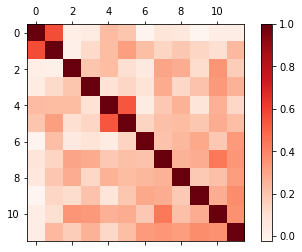

In [7]:
# Plot correlation
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr, cmap=plt.cm.Reds)
fig.colorbar(cax)
plt.show()

- Target 1 and 2 have a relatively higher correlation (`0.56`)
- Target 5 and 6 have a relatively higher correlation (`0.54`)

## Feature Extraction

As a next step, I converted SMILES representation of the molecules (string representation) to **Morgan Fingerprints** which capture important stuctural characteristics of a molecule (bit representation). This representation is commonly used to find smilarities between the molecules. It is also used to indentify whether a molecule has certain properties or not.

Molecular fingerprints directly encode molecular structure in a series of binary bits that represent the presence or absence of particular substructures in the molecule. Although it divides the whole molecule into a large number of fragments, it has the potential to keep overall complexity of a molecule.

Reference: [Building a Molecular Charge Classifier](https://towardsdatascience.com/building-a-molecular-charge-classifier-50204deebd6d) 

In [8]:
# Converting smiles to 256-bit fixed lenght Morgan Fingerprints
mols = [Chem.rdmolfiles.MolFromSmiles(smiles) for smiles in df_data['smiles']]
bi = {}
fps = [rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=255, bitInfo=bi) for mol in mols]

# Representing the fingerprints as numpy array
np_fps_array = []
for fp in fps:
  arr = np.zeros((1,), dtype= int)
  DataStructs.ConvertToNumpyArray(fp, arr)
  np_fps_array.append(arr)

df_data['fps'] = np_fps_array # Adding fingerprints to the data frame

RDKit WARNING: [21:01:46] WARNING: not removing hydrogen atom without neighbors


## Building Classifiers

### Data Preprocessing

For each target, after converting the SMILES into the fingerprints, I removed the data points with `NULL` target values.

Other possibilities for a molecule with null target value is to find all other similar molecules using the fingerprint, and use the most frequent target value instead of null, however that has not been explored in this exercise.

Then, the data was randomly split into a training set (75%) and testing set (25%).

### Classification

I used **Random Forest** to classify the molecules with respect to each target (binary classification with categorical data). In the section below, I showcase the impact of having a high class imbalance.

In a later section, the class imbalance is handled by undersampling from the negative class and results are provided again.

## Model Training

--- target1 ---

Training Features Shape: (5579, 255)
Training Labels Shape: (5579,)
Testing Features Shape: (1860, 255)
Testing Labels Shape: (1860,) 

Cross Validation Accuracy: 0.9724420758621688


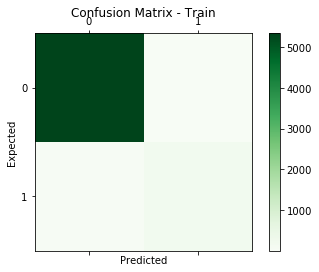

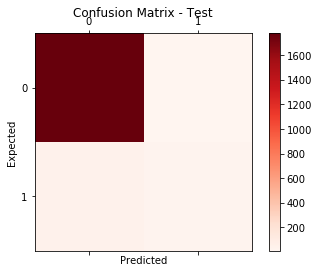

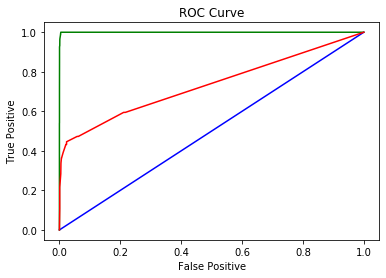

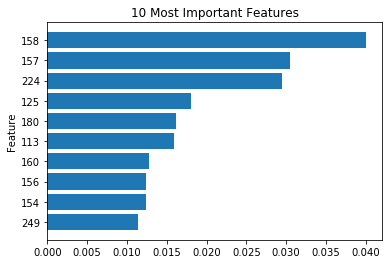



--- target2 ---

Training Features Shape: (5176, 255)
Training Labels Shape: (5176,)
Testing Features Shape: (1726, 255)
Testing Labels Shape: (1726,) 

Cross Validation Accuracy: 0.977251808028844


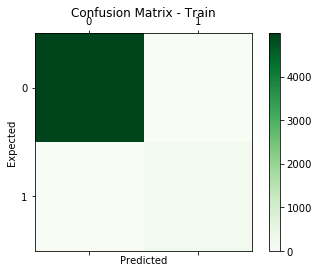

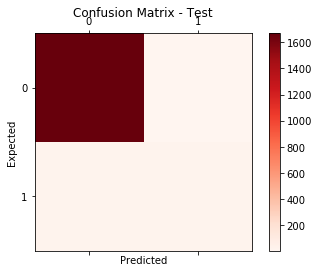

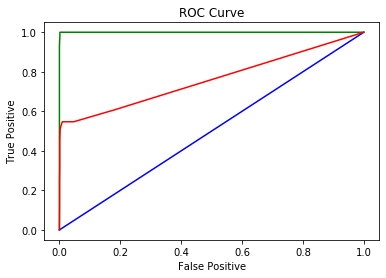

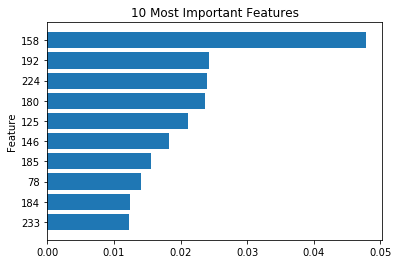



--- target3 ---

Training Features Shape: (5018, 255)
Training Labels Shape: (5018,)
Testing Features Shape: (1673, 255)
Testing Labels Shape: (1673,) 

Cross Validation Accuracy: 0.8961259069438927


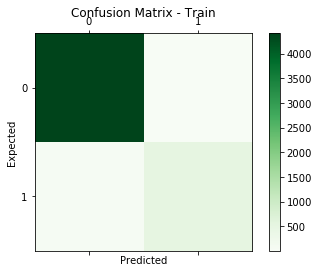

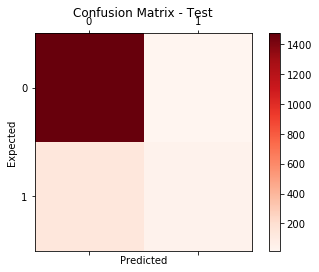

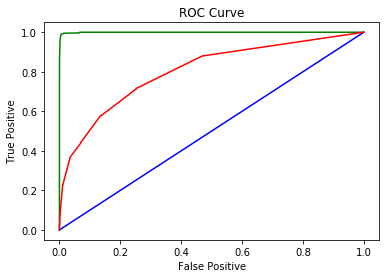

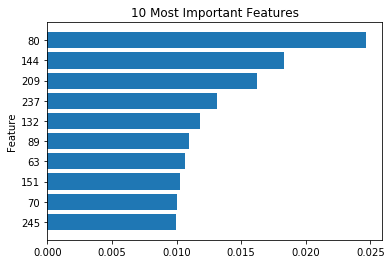



--- target4 ---

Training Features Shape: (4455, 255)
Training Labels Shape: (4455,)
Testing Features Shape: (1485, 255)
Testing Labels Shape: (1485,) 

Cross Validation Accuracy: 0.9535381113795953


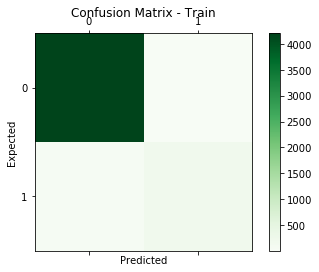

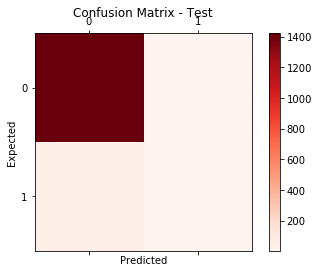

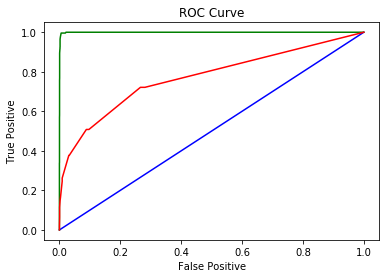

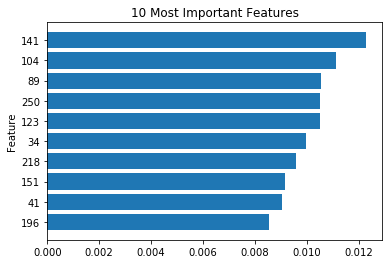



--- target5 ---

Training Features Shape: (4737, 255)
Training Labels Shape: (4737,)
Testing Features Shape: (1579, 255)
Testing Labels Shape: (1579,) 

Cross Validation Accuracy: 0.8799849306811331


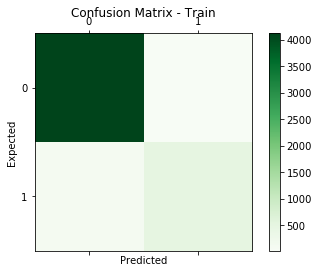

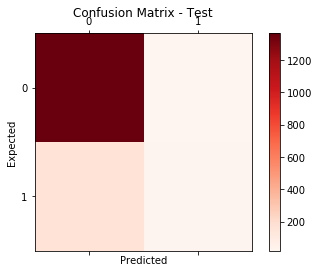

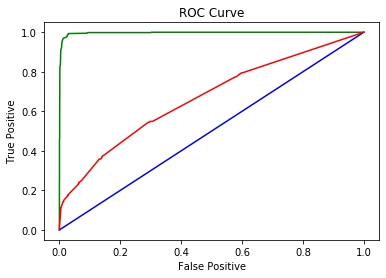

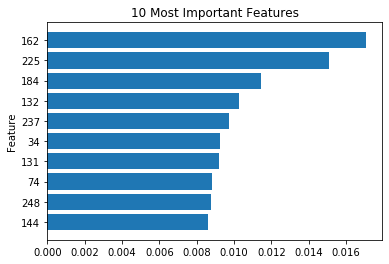



--- target6 ---

Training Features Shape: (5334, 255)
Training Labels Shape: (5334,)
Testing Features Shape: (1778, 255)
Testing Labels Shape: (1778,) 

Cross Validation Accuracy: 0.9597824022788416


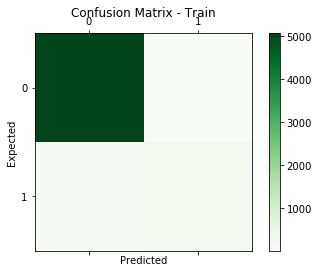

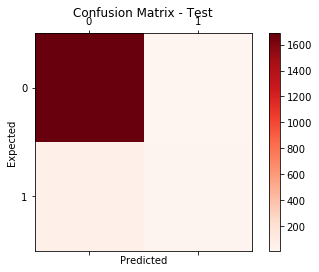

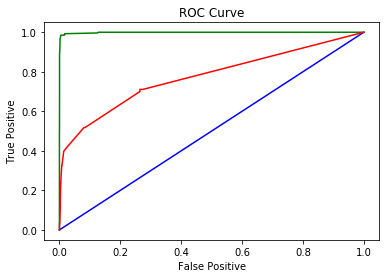

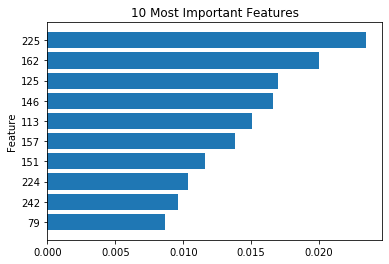



--- target7 ---

Training Features Shape: (4937, 255)
Training Labels Shape: (4937,)
Testing Features Shape: (1646, 255)
Testing Labels Shape: (1646,) 

Cross Validation Accuracy: 0.9725046119084408


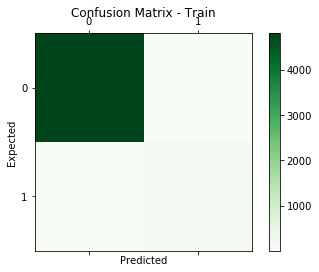

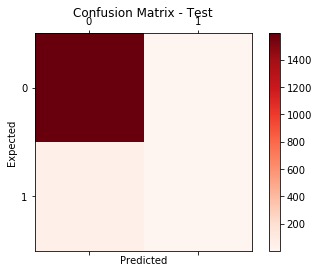

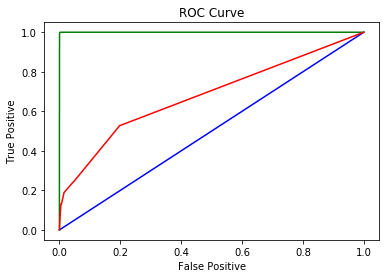

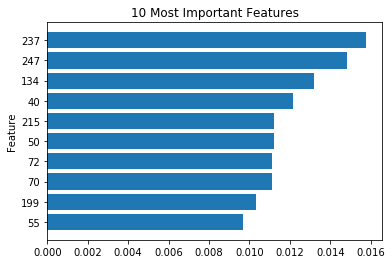



--- target8 ---

Training Features Shape: (4451, 255)
Training Labels Shape: (4451,)
Testing Features Shape: (1484, 255)
Testing Labels Shape: (1484,) 

Cross Validation Accuracy: 0.8530773428829177


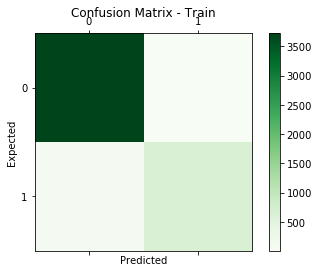

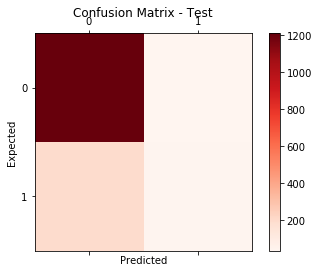

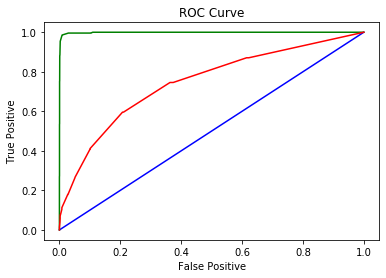

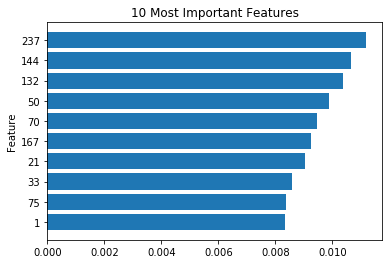



--- target9 ---

Training Features Shape: (5424, 255)
Training Labels Shape: (5424,)
Testing Features Shape: (1808, 255)
Testing Labels Shape: (1808,) 

Cross Validation Accuracy: 0.9637731424225496


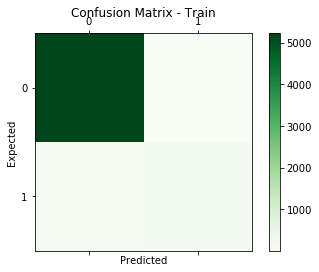

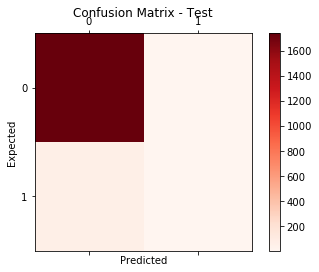

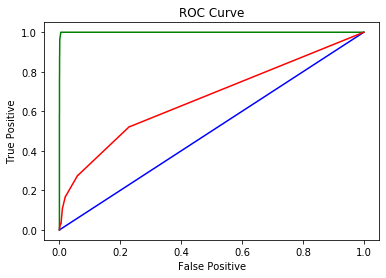

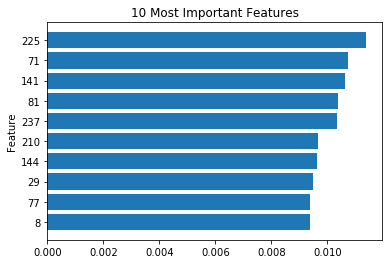



--- target10 ---

Training Features Shape: (4945, 255)
Training Labels Shape: (4945,)
Testing Features Shape: (1649, 255)
Testing Labels Shape: (1649,) 

Cross Validation Accuracy: 0.945102518420247


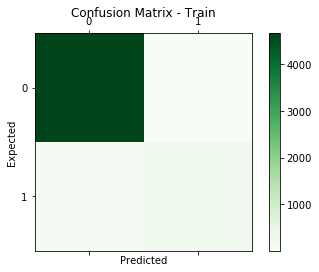

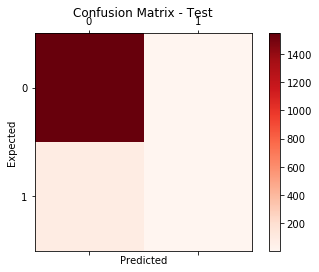

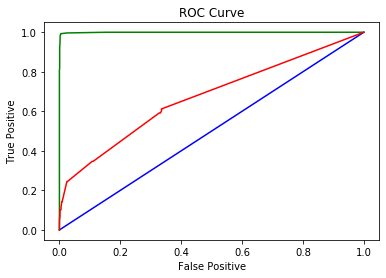

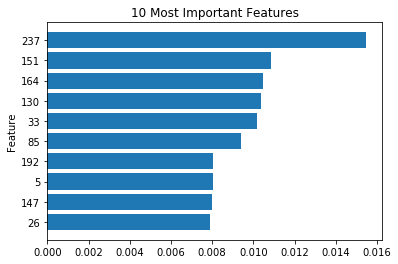



--- target11 ---

Training Features Shape: (4440, 255)
Training Labels Shape: (4440,)
Testing Features Shape: (1480, 255)
Testing Labels Shape: (1480,) 

Cross Validation Accuracy: 0.8726414110993403


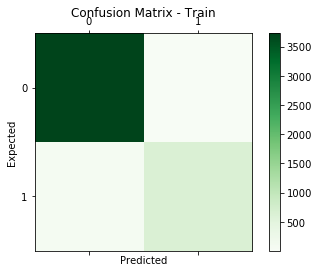

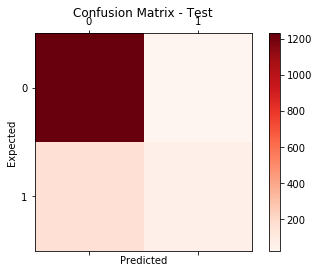

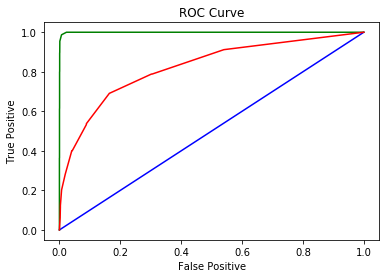

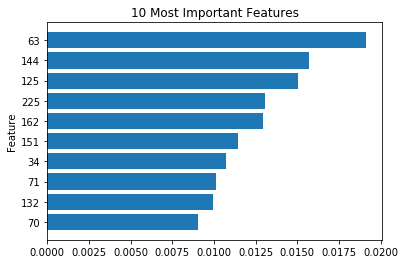



--- target12 ---

Training Features Shape: (5181, 255)
Training Labels Shape: (5181,)
Testing Features Shape: (1728, 255)
Testing Labels Shape: (1728,) 

Cross Validation Accuracy: 0.9423945316141774


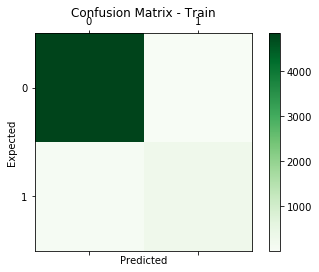

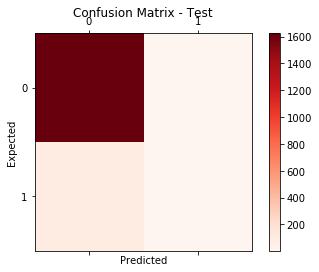

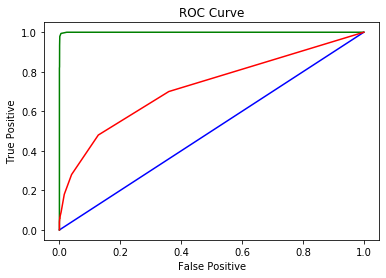

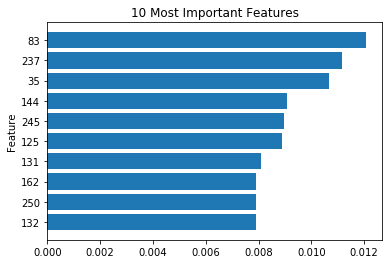

In [9]:
for target in targets:
    print('--- ' + target + ' ---\n')
    
    # Removing records having NULL values w.r.t the respective target
    df_new = df_data[np.isfinite(df_data[target])][['smiles', 'fps', target]]
    
    features = np.array(df_new['fps'].to_list())
    labels = df_new[target]

    # Splitting data into Train and Test
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

    print('Training Features Shape:', train_features.shape)
    print('Training Labels Shape:', train_labels.shape)
    print('Testing Features Shape:', test_features.shape)
    print('Testing Labels Shape:', test_labels.shape, '\n')
    
    # Initializing Random Forest Model
    rf = RandomForestClassifier(n_estimators = 10)
    print('Cross Validation Accuracy:', np.mean(cross_val_score(rf, features, labels, cv=10)))
    rf.fit(train_features, train_labels);
    
    # Analysis
    train_predictions = rf.predict(train_features)
    test_predictions = rf.predict(test_features)
    
    train_probabilities = rf.predict_proba(train_features)[:, 1]
    test_probabilities = rf.predict_proba(test_features)[:, 1]
    
    train_conf_mat = confusion_matrix(y_true = train_labels, y_pred = train_predictions)
    test_conf_mat = confusion_matrix(y_true = test_labels, y_pred = test_predictions)
    
    # Confusion Matrix Plot - Training
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(train_conf_mat, cmap=plt.cm.Greens)
    fig.colorbar(cax)
    plt.title('Confusion Matrix - Train')
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()
    
    # Confusion Matrix Plot - Testing
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(test_conf_mat, cmap=plt.cm.Reds)
    fig.colorbar(cax)
    plt.title('Confusion Matrix - Test')
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()
    
    # ROC Curve
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    train_fpr, train_tpr, _ = roc_curve(train_labels, train_probabilities)
    test_fpr, test_tpr, _ = roc_curve(test_labels, test_probabilities)

    fig = plt.figure()
    plt.title('ROC Curve')
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(train_fpr, train_tpr, 'g', label = 'train')
    plt.plot(test_fpr, test_tpr, 'r', label = 'test')
    plt.show()
    
    # Extracting the imporant features used in the model
    features = [i for i in range(256)]
    importances = rf.feature_importances_
    indices = np.argsort(importances)[-10:]
    
    plt.figure()
    plt.title('10 Most Important Features')
    plt.ylabel('Feature')
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.show()
    
    print('\n')

## Analyzing Initial Results
### Effect of Class Imbalance

With respect to each target, I have reported the following:

    1. Cross-Validation Accuracy
    2. Confusion Matrix - Train
    2. Confusion Matrix - Test
    3. ROC Curve (Base, Train, Test)
    4. Important Features

Even though the cross validation accuracy is high, one can easily observe that the model is predicting `Class 0` for most examples by looking at the confusion matrix. This is easily explained by the **class imbalance** in the data. There are far more data points for the negative class as compared to the positive class.

## Handling Class Imbalance

I resampled the data so that we have equal number of samples from both the positve and negative classes. The model is then retrained and the results are analyzed again.

--- target1 ---

Training Features Shape: (465, 255)
Training Labels Shape: (465,)
Testing Features Shape: (155, 255)
Testing Labels Shape: (155,) 

Cross Validation Accuracy: 0.7225806451612904


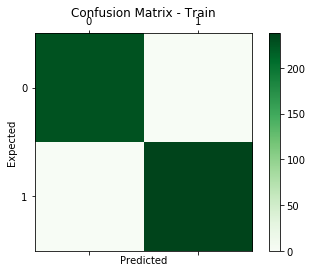

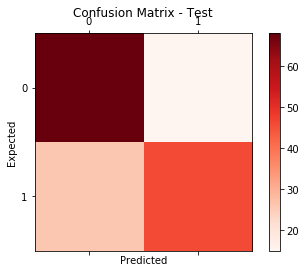

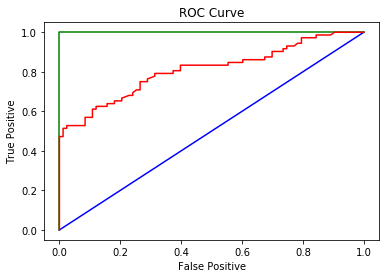

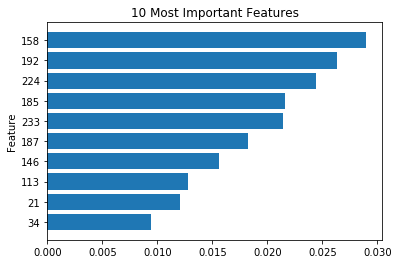



--- target2 ---

Training Features Shape: (357, 255)
Training Labels Shape: (357,)
Testing Features Shape: (119, 255)
Testing Labels Shape: (119,) 

Cross Validation Accuracy: 0.7961956521739131


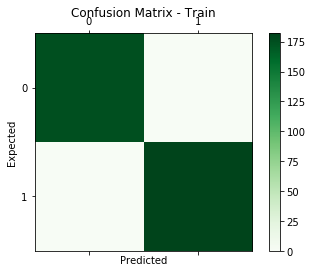

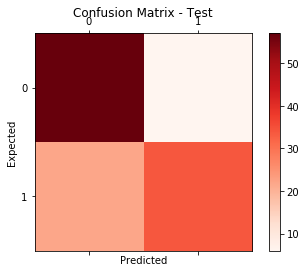

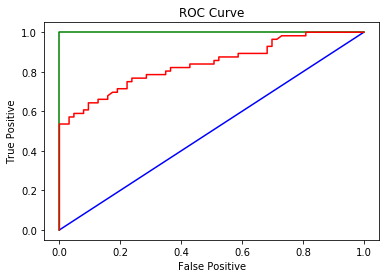

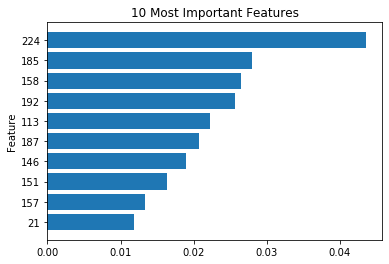



--- target3 ---

Training Features Shape: (1177, 255)
Training Labels Shape: (1177,)
Testing Features Shape: (393, 255)
Testing Labels Shape: (393,) 

Cross Validation Accuracy: 0.7883235962349886


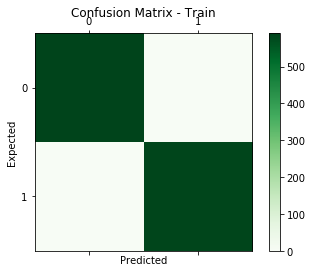

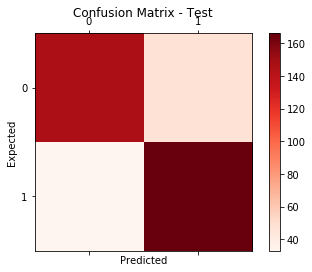

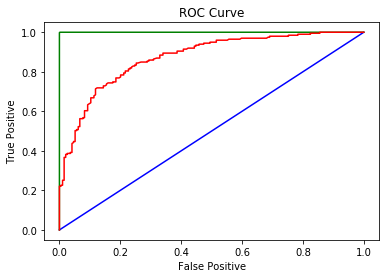

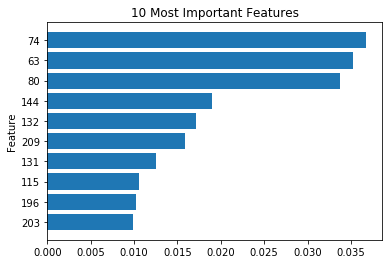



--- target4 ---

Training Features Shape: (460, 255)
Training Labels Shape: (460,)
Testing Features Shape: (154, 255)
Testing Labels Shape: (154,) 

Cross Validation Accuracy: 0.7195698924731182


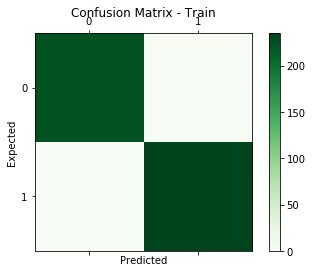

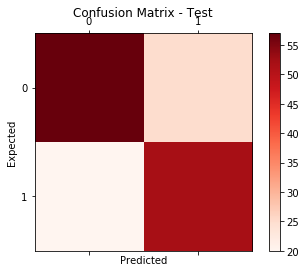

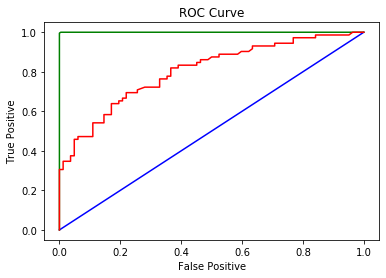

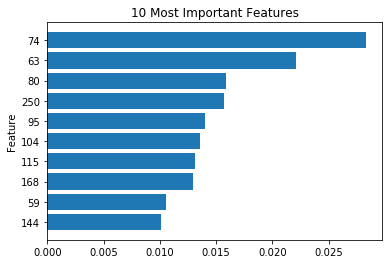



--- target5 ---

Training Features Shape: (1197, 255)
Training Labels Shape: (1197,)
Testing Features Shape: (399, 255)
Testing Labels Shape: (399,) 

Cross Validation Accuracy: 0.6697943037974683


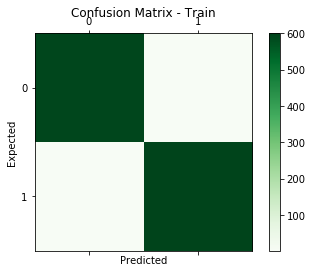

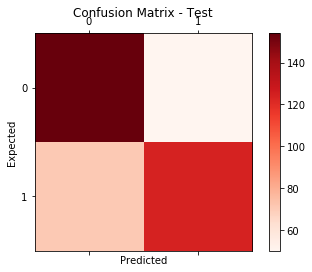

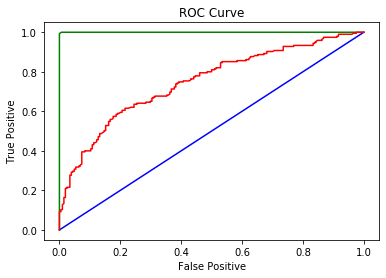

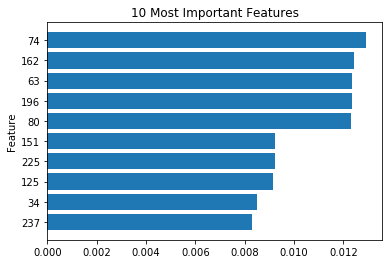



--- target6 ---

Training Features Shape: (534, 255)
Training Labels Shape: (534,)
Testing Features Shape: (178, 255)
Testing Labels Shape: (178,) 

Cross Validation Accuracy: 0.7259523809523809


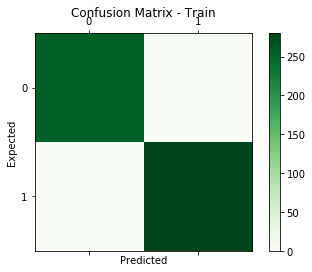

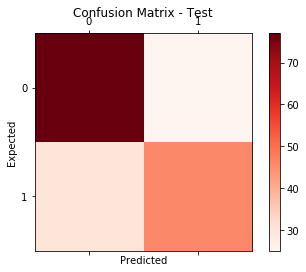

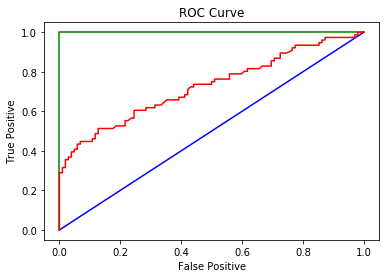

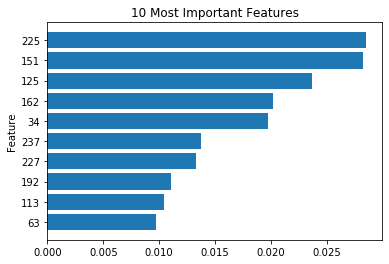



--- target7 ---

Training Features Shape: (283, 255)
Training Labels Shape: (283,)
Testing Features Shape: (95, 255)
Testing Labels Shape: (95,) 

Cross Validation Accuracy: 0.7116959064327486


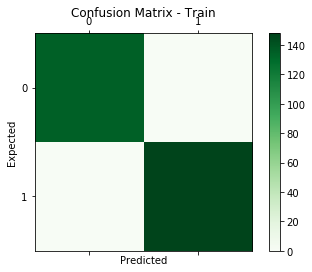

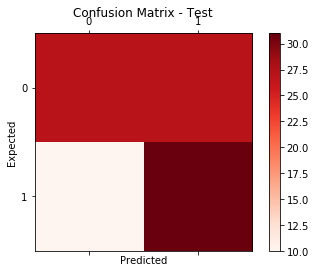

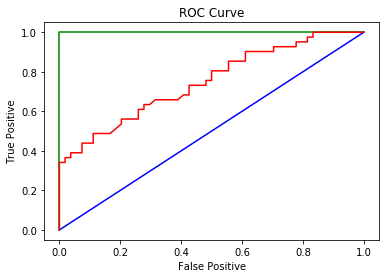

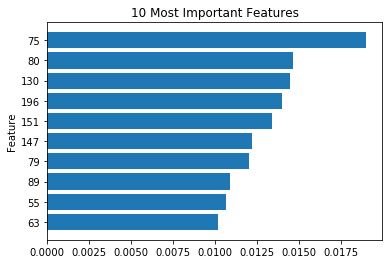



--- target8 ---

Training Features Shape: (1441, 255)
Training Labels Shape: (1441,)
Testing Features Shape: (481, 255)
Testing Labels Shape: (481,) 

Cross Validation Accuracy: 0.6997959621993127


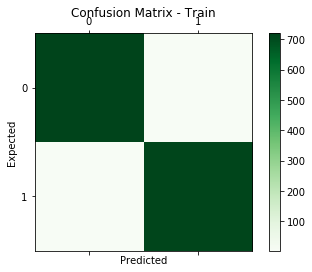

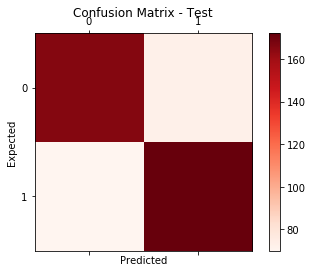

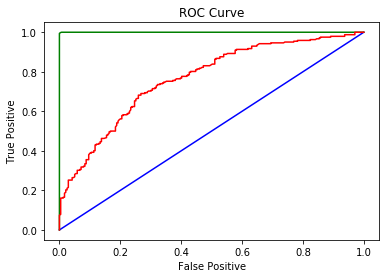

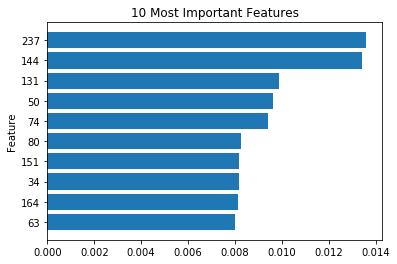



--- target9 ---

Training Features Shape: (400, 255)
Training Labels Shape: (400,)
Testing Features Shape: (134, 255)
Testing Labels Shape: (134,) 

Cross Validation Accuracy: 0.7434472934472934


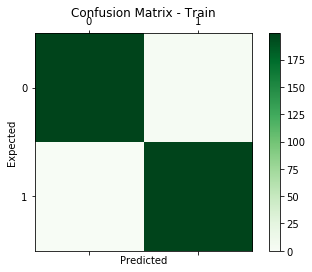

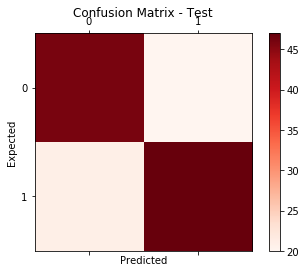

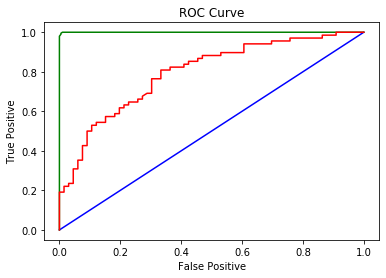

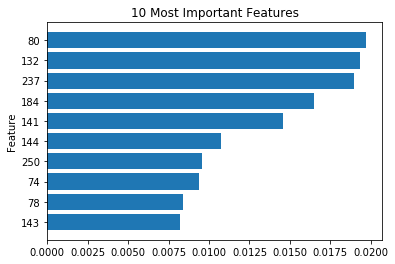



--- target10 ---

Training Features Shape: (568, 255)
Training Labels Shape: (568,)
Testing Features Shape: (190, 255)
Testing Labels Shape: (190,) 

Cross Validation Accuracy: 0.7018492176386912


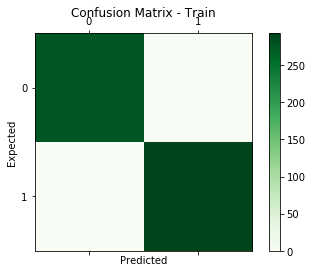

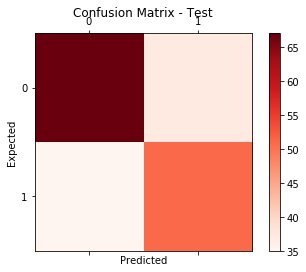

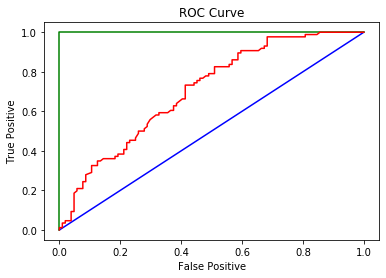

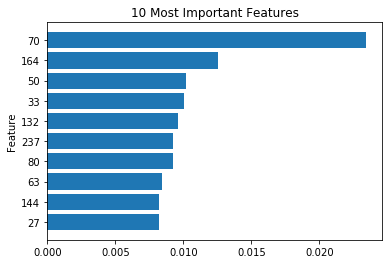



--- target11 ---

Training Features Shape: (1404, 255)
Training Labels Shape: (1404,)
Testing Features Shape: (468, 255)
Testing Labels Shape: (468,) 



In [ ]:
# Have to do this for all the targets

for target in targets:
    print('--- ' + target + ' ---\n')

    ## Undersampling the data to eliminate imbalance
    
    # Data by class
    df_0 = df_data[df_data[target] == 0]
    df_1 = df_data[df_data[target] == 1]

    # Get as many class_0 samples as class_1
    df_balanced_data = pd.concat([df_0.sample(len(df_1)), df_1])[['smiles', 'fps', target]]
    
    features = np.array(df_balanced_data['fps'].to_list())
    labels = df_balanced_data[target]

    # Splitting data into Train and Test
    train_features, test_features, train_labels, test_labels = train_test_split(features,
                                                                                labels,
                                                                                test_size=0.25,
                                                                                random_state = 42) # using random state for repeatability

    # Validating the dimentions of the datasets
    print('Training Features Shape:', train_features.shape)
    print('Training Labels Shape:', train_labels.shape)
    print('Testing Features Shape:', test_features.shape)
    print('Testing Labels Shape:', test_labels.shape, '\n')
    
    # Initializing Random Forest Classifier
    rf = RandomForestClassifier(n_estimators = 1000)
    
    # Cross Validation Accuracy using 10-fold stratified cross validation
    print('Cross Validation Accuracy:', np.mean(cross_val_score(rf, features, labels, cv=10)))
    rf.fit(train_features, train_labels);
    
    # Analysis
    train_predictions = rf.predict(train_features)
    test_predictions = rf.predict(test_features)
    
    train_probabilities = rf.predict_proba(train_features)[:, 1]
    test_probabilities = rf.predict_proba(test_features)[:, 1]
    
    train_conf_mat = confusion_matrix(y_true = train_labels, y_pred = train_predictions)
    test_conf_mat = confusion_matrix(y_true = test_labels, y_pred = test_predictions)
    
    # Conf Matrix - Train
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(train_conf_mat, cmap=plt.cm.Greens)
    fig.colorbar(cax)
    plt.title('Confusion Matrix - Train')
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()
    
    # Conf Matrix - Test
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(test_conf_mat, cmap=plt.cm.Reds)
    fig.colorbar(cax)
    plt.title('Confusion Matrix - Test')
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()
    
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    train_fpr, train_tpr, _ = roc_curve(train_labels, train_probabilities)
    test_fpr, test_tpr, _ = roc_curve(test_labels, test_probabilities)

    # ROC Curve
    fig = plt.figure()
    plt.title('ROC Curve')
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(train_fpr, train_tpr, 'g', label = 'train')
    plt.plot(test_fpr, test_tpr, 'r', label = 'test')
    plt.show()
    
    # Extracting the imporant features used in the model
    features = [i for i in range(256)]
    importances = rf.feature_importances_
    indices = np.argsort(importances)[-10:]

    plt.figure()
    plt.title('10 Most Important Features')
    plt.ylabel('Feature')
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.show()
    
    print('\n')

## Observations

- By observing the *Confusion Matrix*, one can easily see that the model is predicting for both classes unlike the training on imbalanced dataset where the model was predicting the dominant class in most of the instances.
- One can observe that the ROC curves are relatively better

## Scope for further work

Given more time, I would like to read more and explore certain aspects:

1. Learn more about other fingerprinting techniques and their usefulness for target prediction (for example: fingerprints using variable-length list of integers representation versus fixed-length bit string representation).
2. Impute missing target values for certain molecules by checking the similarity of that molecule with other molecules using the fingerprints
3. Use the feature importances presented above to highlight the parts of molecules that are responsible for predicted activitiy
4. Try another sampling approach to tackle class imbalance i.e. oversampling from the positive class
5. Tune the parameters of Random Forest model and check the impact on model accuracy and classification performance, and try different classification models.